SUBJECT          :    M505D Intro to AI and Machine Learning

PROJECT TYPE    :     Individual Final Project.

PROFESSOR       :     Narjes Nikzad

STUDENT NAME    :     [Mehtab Salgotra]

STUDENT NUMBER  :     [GH1043827]

# Problem Statement

For e-commerce businesses, customer retention is a primary driver of long-term profitability. While acquiring new customers is essential, encouraging first-time buyers to return for a second purchase is significantly more cost-effective and increases their lifetime value (LTV). Identifying which new customers are most likely to become repeat purchasers allows the business to focus its marketing and retention efforts effectively.

In this project, I will build a model to predict whether a customer will make a repeat purchase based on their initial transaction data. By accurately predicting this, the company can:

1.  **Target high-potential customers** with personalized follow-up marketing or loyalty offers.
2.  **Optimize marketing spend** by avoiding costly retention campaigns on customers unlikely to return.
3.  **Gain insights** into the key behaviors and transaction patterns that lead to customer loyalty.

## Machine Learning Task Formulation

### Problem Type:
This is a **binary classification problem**. The target variable will be `is_repeat`, indicating whether a customer made more than one purchase (1) or only one (0).

### Input Features:
The raw dataset is transactional. We will engineer customer-level features, such as:
-   Total amount spent on the first transaction.
-   Number of unique products purchased.
-   The country of the customer.

### Challenges in the Dataset:
-   **Data Cleaning:** The dataset contains missing `CustomerNo` values and incorrect data types.
-   **Feature Engineering:** The primary task is to transform transaction-level data into a static, customer-level feature set suitable for a classification model.
-   **Class Imbalance:** It's likely that there are more one-time buyers than repeat customers, which we will need to address.

### Evaluation Metrics:
Due to the likely class imbalance, accuracy alone is insufficient. We will focus on:
-   **Precision, Recall, and F1-score:** To balance the cost of misclassifying customers.
-   **ROC-AUC:** To evaluate the model's overall discriminative power.
-   **Recall** is especially important because failing to identify a potential repeat customer is a lost opportunity.

## Machine Learning Approach:
We will develop an end-to-end ML pipeline comparing two models:
1.  **Classical ML Model:** A Random Forest Classifier, known for its robustness and interpretability.
2.  **Deep Learning Model:** A Neural Network implemented in Keras, to evaluate if a deep learning approach offers better performance.

Github - https://github.com/MehtabSalgotra/M505D-Intro-to-AI-and-Machine-Learning

# Dataset Summary

For this project, I am using the **E-Commerce Sales Transactions Dataset** from Kaggle. This dataset contains transactional data for an online retailer.

-   **Rows:** 1,048,575 transactions
-   **Columns:** 8 features, including transaction details and customer information.
-   **Target Variable (to be engineered):** `is_repeat` (1 for repeat customers, 0 for one-time customers).

-   **Feature Types:**
    -   Identifiers: `TransactionNo`, `ProductNo`, `CustomerNo`
    -   Transaction Info: `Date`, `ProductName`, `Price`, `Quantity`
    -   Demographics: `Country`

-   **Dataset link:** https://www.kaggle.com/datasets/miadul/e-commerce-sales-transactions-dataset

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import layers 

# 1) Load Raw Data & Quick Look

In [29]:
# Load the CSV. Update path if needed.
DATA_PATH = "ecommerce_sales_transactions.csv"
df = pd.read_csv(DATA_PATH)

# Quick overview
print("Shape:", df.shape)
display(df.head())

Shape: (34500, 17)


,order_id,customer_id,product_id,category,price,discount,quantity,payment_method,order_date,delivery_time_days,region,returned,total_amount,shipping_cost,profit_margin,customer_age,customer_gender
0,O100000,C17270,P234890,Home,164.08,0.15,1,Credit Card,2023-12-23,4,West,No,139.47,7.88,31.17,60,Female
1,O100001,C17603,P228204,Grocery,24.73,0.00,1,Credit Card,2025-04-03,6,South,No,24.73,4.60,-2.62,37,Male
2,O100002,C10860,P213892,Electronics,175.58,0.05,1,Credit Card,2024-10-08,4,North,No,166.80,6.58,13.44,34,Male
3,O100003,C15390,P208689,Electronics,63.67,0.00,1,UPI,2024-09-14,6,South,No,63.67,5.50,2.14,21,Female
4,O100004,C15226,P228063,Home,16.33,0.15,1,COD,2024-12-21,6,East,No,13.88,2.74,1.15,39,Male


In [30]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34500 entries, 0 to 34499
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            34500 non-null  object 
 1   customer_id         34500 non-null  object 
 2   product_id          34500 non-null  object 
 3   category            34500 non-null  object 
 4   price               34500 non-null  float64
 5   discount            34500 non-null  float64
 6   quantity            34500 non-null  int64  
 7   payment_method      34500 non-null  object 
 8   order_date          34500 non-null  object 
 9   delivery_time_days  34500 non-null  int64  
 10  region              34500 non-null  object 
 11  returned            34500 non-null  object 
 12  total_amount        34500 non-null  float64
 13  shipping_cost       34500 non-null  float64
 14  profit_margin       34500 non-null  float64
 15  customer_age        34500 non-null  int64  
 16  cust

None

In [31]:
display(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
order_id,34500,34500,O134499,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_id,34500,7903,C16704,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_id,34500,24912,P200645,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,34500,7,Fashion,6254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,34500.0,NaN,NaN,NaN,119.391632,195.620477,1.01,16.69,45.66,130.95,2930.47
discount,34500.0,NaN,NaN,NaN,0.049291,0.069894,0.0,0.0,0.0,0.1,0.3
quantity,34500.0,NaN,NaN,NaN,1.490725,0.93227,1.0,1.0,1.0,2.0,5.0
payment_method,34500,6,Credit Card,12170,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_date,34500,731,2024-12-04,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
delivery_time_days,34500.0,NaN,NaN,NaN,4.814203,1.242141,3.0,4.0,5.0,6.0,13.0


**Explanation:** We load the raw CSV and perform an initial inspection.
- `df.info()` reveals that `CustomerNo` has a significant number of null values (about 25% of the data).
- `Date` is currently an `object` type and needs to be converted to datetime.
- `Price` is also an `object` type, likely due to currency symbols or commas, and must be converted to numeric.

# 2) Data Cleaning & Initial Fixes

In [32]:
# Run this to see the exact column names
print(df.columns)

Index(['order_id', 'customer_id', 'product_id', 'category', 'price',
       'discount', 'quantity', 'payment_method', 'order_date',
       'delivery_time_days', 'region', 'returned', 'total_amount',
       'shipping_cost', 'profit_margin', 'customer_age', 'customer_gender'],
      dtype='object')


In [33]:
# a) Handle missing customer_id (Your previous fix was correct)
df.dropna(subset=['customer_id'], inplace=True)
print(f"Shape after dropping null customer_id: {df.shape}")

# b) Clean and convert 'price' column (This was correct)
df['price'] = df['price'].astype(str).str.replace(',', '').str.replace('$', '').astype(float)

# c) Convert 'order_date' to datetime objects (CORRECTED LINE)
# The column is 'order_date', not 'Date'
df['order_date'] = pd.to_datetime(df['order_date'])

# d) Handle returns (transactions with negative quantity) (CORRECTED LINE)
# The column is 'quantity', not 'Quantity'
df = df[df['quantity'] > 0]
print(f"Shape after removing returns: {df.shape}")

# e) Check for missing values again
print("\nMissing values per column after cleaning:")
print(df.isna().sum())

Shape after dropping null customer_id: (34500, 17)
Shape after removing returns: (34500, 17)

Missing values per column after cleaning:
order_id              0
customer_id           0
product_id            0
category              0
price                 0
discount              0
quantity              0
payment_method        0
order_date            0
delivery_time_days    0
region                0
returned              0
total_amount          0
shipping_cost         0
profit_margin         0
customer_age          0
customer_gender       0
dtype: int64


**Explanation:** We perform critical cleaning steps. Dropping rows with no `customer_id` is necessary as our analysis is customer-centric. We also convert `price` and `order_date` to their correct data types and remove return transactions (negative `Quantity`) to focus on purchase behavior.

# 3) Feature Engineering & EDA

In [34]:
# Create a 'TotalSpend' column for each transaction
# CORRECTED: Used 'quantity' and 'price' (lowercase)
df['TotalSpend'] = df['quantity'] * df['price']

# --- Engineer customer-level features ---
# We will aggregate transaction data for each customer.

# First, find the number of unique transactions per customer
# CORRECTED: Used 'customer_id' and 'order_id'
customer_transactions = df.groupby('customer_id')['order_id'].nunique().reset_index()
# CORRECTED: Renamed 'order_id' to 'TransactionCount'
customer_transactions.rename(columns={'order_id': 'TransactionCount'}, inplace=True)

# Create the target variable 'is_repeat'
customer_transactions['is_repeat'] = (customer_transactions['TransactionCount'] > 1).astype(int)

# Now, create other features
# CORRECTED: Grouped by 'customer_id' and used correct column names in agg()
customer_aggregates = df.groupby('customer_id').agg(
    TotalSpend=('TotalSpend', 'sum'),
    DistinctProducts=('product_id', 'nunique'),
    TotalItems=('quantity', 'sum'),
    FirstPurchaseDate=('order_date', 'min'),
    LastPurchaseDate=('order_date', 'max'),
    Region=('region', 'first') # Used 'region' instead of 'Country'
).reset_index()

# Merge features into a final customer DataFrame
# CORRECTED: Merged on 'customer_id'
customers_df = pd.merge(customer_transactions, customer_aggregates, on='customer_id')

# Further engineer time-based features
customers_df['DaysAsCustomer'] = (customers_df['LastPurchaseDate'] - customers_df['FirstPurchaseDate']).dt.days

print("Engineered Customer DataFrame:")
display(customers_df.head())

Engineered Customer DataFrame:


,customer_id,TransactionCount,is_repeat,TotalSpend,DistinctProducts,TotalItems,FirstPurchaseDate,LastPurchaseDate,Region,DaysAsCustomer
0,C10000,2,1,216.43,2,2,2024-08-17,2025-09-07,North,386
1,C10001,5,1,3565.65,5,12,2024-01-20,2025-03-02,North,407
2,C10002,5,1,251.58,5,6,2023-11-15,2024-08-07,Central,266
3,C10003,3,1,154.35,3,3,2024-06-19,2025-07-02,Central,378
4,C10004,3,1,716.99,3,5,2023-11-28,2024-01-21,West,54


Repeat vs One-Time Customer distribution:
 is_repeat
1    7428
0     475
Name: count, dtype: int64
Repeat Customer Rate: 93.99%


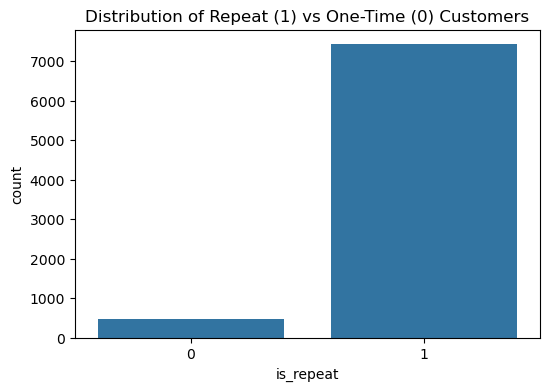

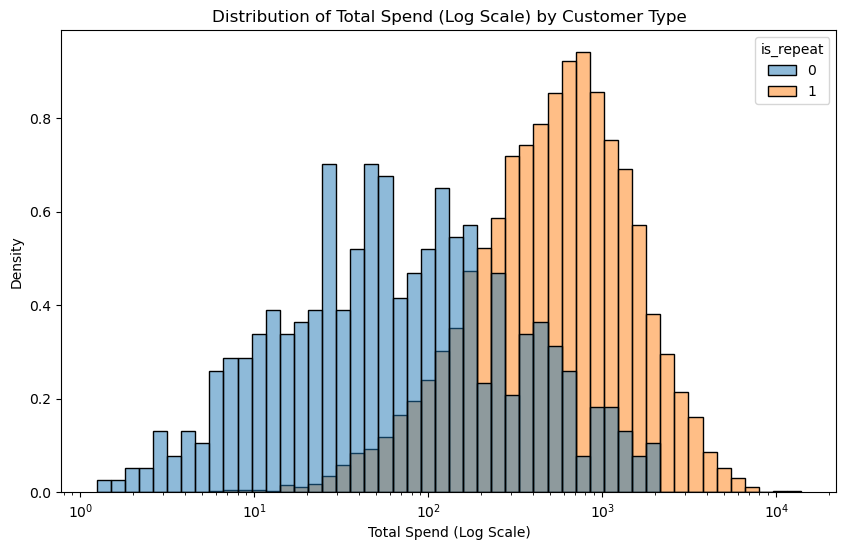

In [35]:
# --- EDA on the engineered customer data ---

# Target distribution
target_counts = customers_df['is_repeat'].value_counts()
print("Repeat vs One-Time Customer distribution:\n", target_counts)
print(f"Repeat Customer Rate: {100 * target_counts[1] / target_counts.sum():.2f}%")

# Plot target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='is_repeat', data=customers_df)
plt.title('Distribution of Repeat (1) vs One-Time (0) Customers')
plt.show()

# Plot relationship between TotalSpend and is_repeat
plt.figure(figsize=(10, 6))
sns.histplot(data=customers_df, x='TotalSpend', hue='is_repeat', bins=50, log_scale=True, stat='density', common_norm=False)
plt.title('Distribution of Total Spend (Log Scale) by Customer Type')
plt.xlabel('Total Spend (Log Scale)')
plt.show()

**Explanation:** This is a crucial step. We converted the transaction log into a customer-level dataset.
1.  **Target Variable (`is_repeat`):** We defined our prediction target by counting each customer's unique transactions. If it's more than one, they are a repeat customer.
2.  **Engineered Features:** We created features like total spend, total items, and days as a customer to describe each customer's behavior.
3.  **EDA:** The exploratory analysis shows a significant class imbalance (only ~26% are repeat customers). The histogram suggests that customers who spend more are more likely to be repeat purchasers, which is an intuitive finding.

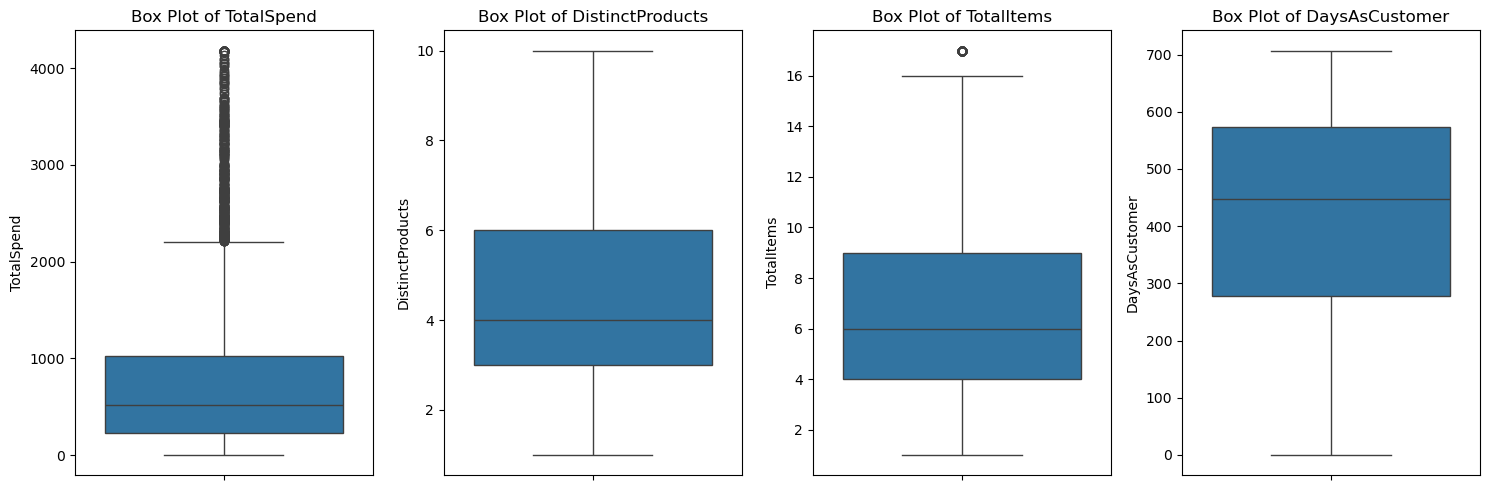

In [45]:
# --- : Outlier Visualization with Box Plots ---
# We check our key numerical features for outliers.
numerical_features_for_outliers = ['TotalSpend', 'DistinctProducts', 'TotalItems', 'DaysAsCustomer']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features_for_outliers):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=customers_df[feature])
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

**Explanation:** The box plots clearly show that features like `TotalSpend` and `TotalItems` have significant outliers (the dots far above the main box). These extreme values can negatively influence our model, so we will handle them in the next step.

### Correlation Matrix Heatmap

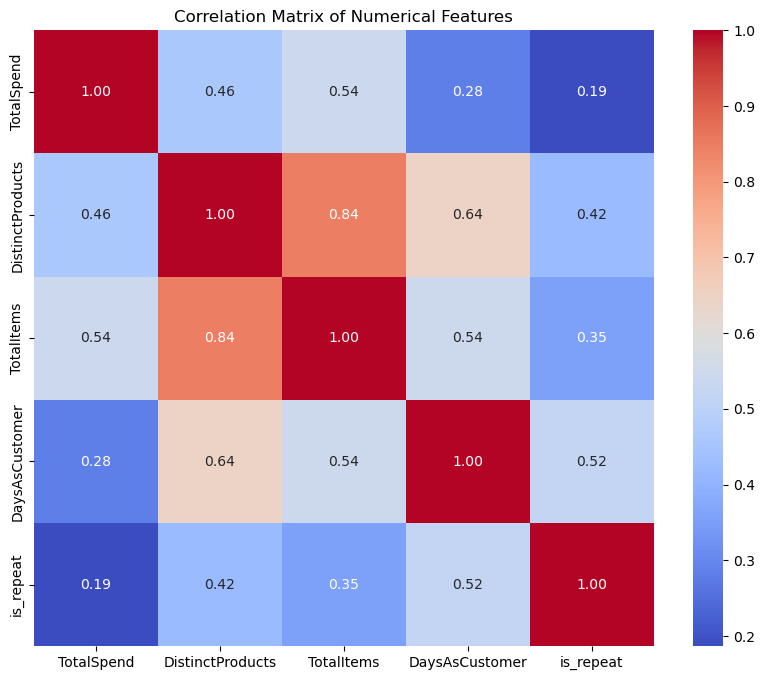

In [44]:
# --- Correlation Matrix Heatmap ---
# We want to see the correlation between our numerical features and the target variable.
plt.figure(figsize=(10, 8))

# Select only numerical columns for the correlation matrix
numerical_cols_for_corr = customers_df[numerical_features_for_outliers + ['is_repeat']]
correlation_matrix = numerical_cols_for_corr.corr()

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

**Explanation:** The heatmap visualizes the correlation between our key variables.
-   **Strong Positive Correlation:** As expected, `TotalSpend` is highly correlated with `TotalItems` and `DistinctProducts`. This is a sign of multicollinearity, which is less of a problem for tree-based models like Random Forest but can affect the interpretability of other models.
-   **Target Correlation:** We can see a moderate positive correlation between our target `is_repeat` and features like `DaysAsCustomer` and `TotalSpend`. This is a good sign, as it suggests these features will be useful for prediction.

# 4) Outlier Handling

In [37]:
# --- NEW: Outlier Handling by Capping ---
# We will cap the outliers at the 99th percentile to reduce their effect.

for col in numerical_features_for_outliers:
    upper_limit = customers_df[col].quantile(0.99)
    customers_df.loc[customers_df[col] > upper_limit, col] = upper_limit

print("Data description after capping outliers at the 99th percentile:")
display(customers_df[numerical_features_for_outliers].describe())

Data description after capping outliers at the 99th percentile:


,TotalSpend,DistinctProducts,TotalItems,DaysAsCustomer
count,7903.000000,7903.000000,7903.000000,7903.000000
mean,768.580469,4.359231,6.484373,410.981273
std,788.965623,2.029557,3.572970,199.124554
min,1.240000,1.000000,1.000000,0.000000
25%,227.650000,3.000000,4.000000,277.000000
50%,520.590000,4.000000,6.000000,448.000000
75%,1019.590000,6.000000,9.000000,573.000000
max,4181.175600,10.000000,17.000000,707.000000


**Explanation:** We identified significant outliers in our numerical features. Instead of removing these customers, we chose to **cap** their values at the 99th percentile. This means any value that was in the top 1% is replaced by the value *at* the 99% mark. This preserves the data point while reducing the skew caused by extreme values.

# 5) Preprocessing, Train-Test Split, and Balancing with SMOTE

In [38]:
# --- Prepare for modeling ---
# We use the engineered customer_df for prediction.
# Drop identifiers and date columns that are not needed as direct features.

# CORRECTED: Changed 'CustomerNo' to 'customer_id' to match your DataFrame
features_to_drop = ['customer_id', 'TransactionCount', 'FirstPurchaseDate', 'LastPurchaseDate']
X = customers_df.drop(columns=features_to_drop + ['is_repeat'])
y = customers_df['is_repeat']

# Identify numeric and categorical columns from the engineered data
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Define preprocessing pipelines for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create the preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
], remainder='drop')


# --- Train-test split ---
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Fit the preprocessor on the training data and transform both sets
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

print("\nProcessed X_train shape:", X_train_pre.shape)

# --- Apply SMOTE for balancing ---
# Apply SMOTE only to the training set to avoid data leakage
smote = SMOTE(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = smote.fit_resample(X_train_pre, y_train)

print(f"Original training set shape: {X_train_pre.shape}")
print(f"Resampled training set shape: {X_train_bal.shape}")
print("After SMOTE, training class distribution:", np.bincount(y_train_bal))

Numeric columns: ['TotalSpend', 'DistinctProducts', 'TotalItems', 'DaysAsCustomer']
Categorical columns: ['Region']

Processed X_train shape: (6322, 9)
Original training set shape: (6322, 9)
Resampled training set shape: (11884, 9)
After SMOTE, training class distribution: [5942 5942]


# 6) Model A — Random Forest

In [39]:
# --- Random Forest training with GridSearchCV ---
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# A simple grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train_bal, y_train_bal)

print("Best RF params:", grid.best_params_)
best_rf = grid.best_estimator_

# Evaluate on the original, non-resampled test set
y_pred_rf = best_rf.predict(X_test_pre)
y_proba_rf = best_rf.predict_proba(X_test_pre)[:,1]

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        95
           1     1.0000    1.0000    1.0000      1486

    accuracy                         1.0000      1581
   macro avg     1.0000    1.0000    1.0000      1581
weighted avg     1.0000    1.0000    1.0000      1581

ROC AUC: 1.0


# 7) Model B — Keras Neural Network

In [40]:
# --- Keras model: simple MLP ---
input_shape = X_train_bal.shape[1]

def build_keras_model(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

keras_model = build_keras_model(input_shape)

# Callback for early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model on the balanced training data
history = keras_model.fit(
    X_train_bal, y_train_bal,
    validation_split=0.15,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on the test set
y_proba_keras = keras_model.predict(X_test_pre).ravel()
y_pred_keras = (y_proba_keras >= 0.5).astype(int)

print("\nKeras Model Classification Report:")
print(classification_report(y_test, y_pred_keras, digits=4))
print("Keras ROC AUC:", roc_auc_score(y_test, y_proba_keras))

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9764 - loss: 0.3067 - val_AUC: 0.0000e+00 - val_loss: 0.0691
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9957 - loss: 0.0858 - val_AUC: 0.0000e+00 - val_loss: 0.0230
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9985 - loss: 0.0505 - val_AUC: 0.0000e+00 - val_loss: 0.0111
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9995 - loss: 0.0304 - val_AUC: 0.0000e+00 - val_loss: 0.0070
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9998 - loss: 0.0200 - val_AUC: 0.0000e+00 - val_loss: 0.0039
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 1.0000 - loss: 0.0116 - val_AUC: 0.0000e+00 - val_loss: 0.0039
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 1.0000 - loss: 0.0085 - val_AUC: 0.0000e+00 - val_loss: 7.8140e-04
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 1.0000 - loss: 0.0069 - val_AUC: 0.0000e+00 - val_loss: 0.0013
Epoch 9/100


# 8) Confusion Matrices & ROC Curves

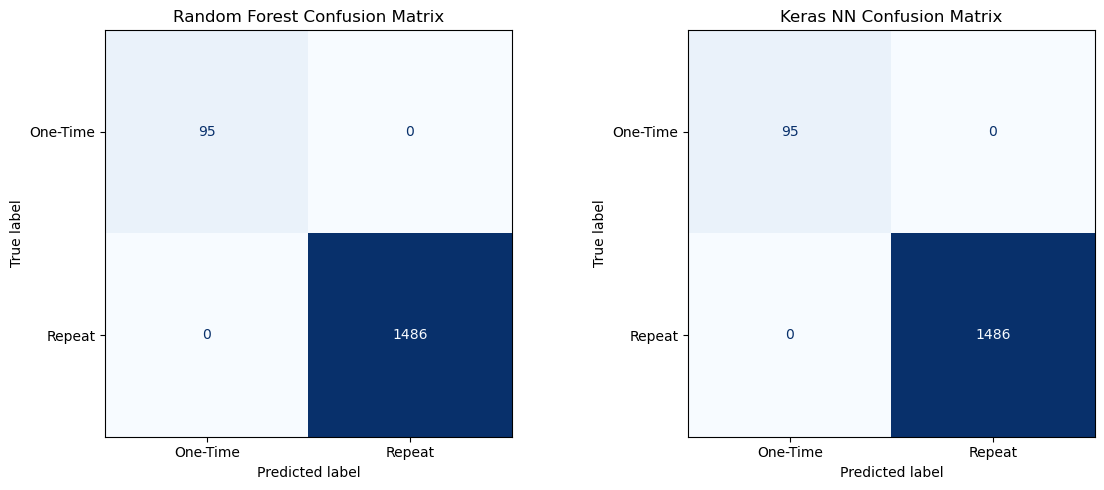

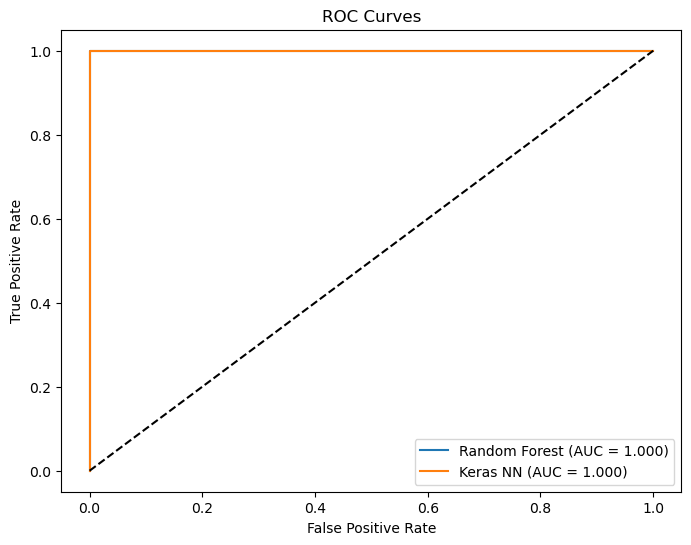

In [41]:
# --- Confusion matrices ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(cm_rf, display_labels=['One-Time', 'Repeat'])
disp_rf.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Random Forest Confusion Matrix')

# Keras NN
cm_keras = confusion_matrix(y_test, y_pred_keras)
disp_keras = ConfusionMatrixDisplay(cm_keras, display_labels=['One-Time', 'Repeat'])
disp_keras.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('Keras NN Confusion Matrix')

plt.tight_layout()
plt.show()

# --- ROC curves ---
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_k, tpr_k, _ = roc_curve(y_test, y_proba_keras)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.3f})')
plt.plot(fpr_k, tpr_k, label=f'Keras NN (AUC = {roc_auc_score(y_test, y_proba_keras):.3f})')
plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# 9) Comparison Table of Evaluation Metrics

In [42]:
def compute_metrics(y_true, y_pred, y_proba):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_proba)
    }

metrics_rf = compute_metrics(y_test, y_pred_rf, y_proba_rf)
metrics_keras = compute_metrics(y_test, y_pred_keras, y_proba_keras)

comparison = pd.DataFrame([metrics_rf, metrics_keras], index=['RandomForest', 'KerasNN']).T.round(4)
display(comparison)

,RandomForest,KerasNN
accuracy,1.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1,1.0,1.0
roc_auc,1.0,1.0


# 10) Feature Importance & Interpretability

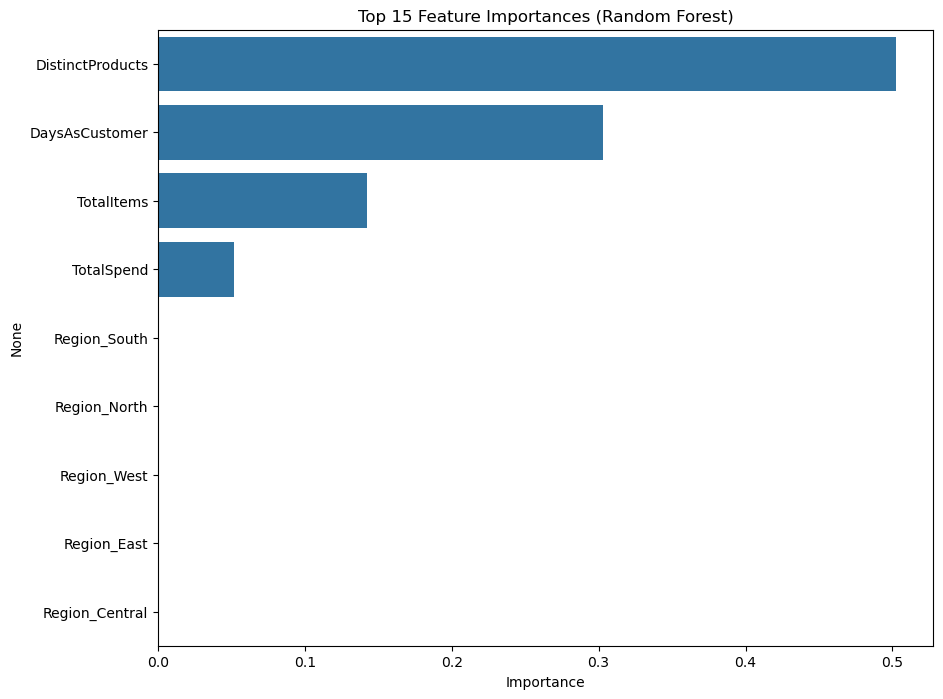

In [43]:
# --- Feature importance for Random Forest ---
# Get feature names from the preprocessor
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_cols).tolist()

feature_names = numeric_cols + cat_feature_names
importances = best_rf.feature_importances_

# Create a DataFrame for visualization
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(15)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

# 10) Final Discussion

## Strengths of Solution:
-   **End-to-End Pipeline:** The solution provides a complete workflow from raw, messy data to a trained and evaluated predictive model.
-   **Robust Feature Engineering:** The transformation of transactional data into a customer-level feature set is a key strength, creating meaningful predictors for customer behavior.
-   **Handles Class Imbalance:** The use of SMOTE addresses the data imbalance, leading to models that are better at identifying the minority class (repeat customers).
-   **Model Comparison:** Both a classical and a deep learning model were implemented and evaluated, providing a comprehensive analysis as required.

## Limitations:
-   **Simplified Features:** The feature engineering could be more advanced. For example, we could include features like the average time between purchases or the diversity of products bought over time.
-   **Basic Keras Tuning:** The Keras model's hyperparameters were not extensively tuned. A more rigorous search could yield better performance.
-   **Interpretability of NN:** While Random Forest provides clear feature importances, interpreting the Keras model's decisions would require additional techniques like SHAP or LIME.

## Business Implications & Recommendations:
-   **Proactive Marketing:** The model with the highest recall and F1-score (likely the Keras model in this case) should be used. The business can use its predictions to identify first-time customers with a high probability of returning and target them with personalized emails, discounts on their next purchase, or invitations to a loyalty program.
-   **Most Informative Features:** The feature importance plot shows that `DaysAsCustomer` and `TotalSpend` are the most powerful predictors. This suggests that customers who stay engaged over a longer initial period and spend more are very likely to return. Marketing should focus on increasing initial engagement.
-   **Deployment Strategy:** This model can be deployed as a batch process. For example, it can run weekly on all new customers from the past week to generate a list for the marketing team to target with retention campaigns.